# Math Question Answer Verification Competition

## Starter Code

Borrowed from [official Unsloth implementation](https://colab.research.google.com/drive/1Ys44kVvmeZtnICzWz0xgpRnrIOjZAuxp?usp=sharing#scrollTo=MKX_XKs_BNZR)

In [1]:
# %%capture
# This cell will take time
!pip install unsloth
# Also get the latest nightly Unsloth!
!pip uninstall unsloth -y && pip install --upgrade --no-cache-dir "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.6/59.6 kB 2.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 161.8/161.8 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.2/310.2 kB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 95.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 64.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 73.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.


In [3]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
)

==((====))==  Unsloth 2024.11.5: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.70G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/230 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/50.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.09M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

## Load model and wrap with LoRA adapters

In [4]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",],
    lora_alpha = 128,
    lora_dropout = 0, # Supports any, but = 0 is optimized
    bias = "none",    # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing = "unsloth", # True or "unsloth" for very long context
    random_state = 42,
    use_rslora = False,  # We support rank stabilized LoRA
    # loftq_config = None, # And LoftQ
    loftq_config={
        "loftq_bits": 4,
        "loftq_iter": 1
    }
)

Unsloth 2024.11.5 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


## Competition dataset

In [5]:
# download and load competition dataset

from datasets import load_dataset
dataset = load_dataset("ad6398/nyu-dl-teach-maths-comp")
# print and see dataset
dataset

README.md:   0%|          | 0.00/2.09k [00:00<?, ?B/s]

train-00000-of-00002.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

train-00001-of-00002.parquet:   0%|          | 0.00/195M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/3.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 1000000
    })
    test: Dataset({
        features: ['question', 'is_correct', 'answer', 'solution'],
        num_rows: 10000
    })
})

In [6]:
prompt = """You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.
Your answer should follow these steps
1. Question Analysis: Read the question carefully and identify what is being asked.
2. Given Solution Review: Review the provided solution approach.
3. Independent Verification: Solve the problem independently, showing each step.
4. Comparison: Compare your solution with the given answer.
5. Respond ONLY with 'True' if the answer is correct, or 'False' if incorrect.


### Question:
{}

### Given Answer:
{}

### Step-by-step verification:
1) First, I will solve independently
2) Then compare with the given solution and answer
3) Finally, verify if they match

### Output:
{}"""

EOS_TOKEN = tokenizer.eos_token # Must add EOS_TOKEN
def formatting_prompts_func(examples):
    question = examples["question"]
    ans       = examples["answer"]
    output      = examples["is_correct"]
    texts = []
    for instruction, input, output in zip(question, ans, output):
        # Must add EOS_TOKEN, otherwise your generation will go on forever!
        text = prompt.format(instruction, input, output) + EOS_TOKEN
        texts.append(text)
    return { "text" : texts, }




In [7]:
# Process the training dataset and generate prompt for each datapoint

train_dataset = dataset['train'].map(formatting_prompts_func, batched = True,)

Map:   0%|          | 0/1000000 [00:00<?, ? examples/s]

In [8]:
#print a smaple training example
train_dataset['text'][0]

"You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.\nYour answer should follow these steps\n1. Question Analysis: Read the question carefully and identify what is being asked.\n2. Given Solution Review: Review the provided solution approach.\n3. Independent Verification: Solve the problem independently, showing each step.\n4. Comparison: Compare your solution with the given answer.\n5. Respond ONLY with 'True' if the answer is correct, or 'False' if incorrect.\n\n\n### Question:\nWhat is the radius of the circle inscribed in triangle $ABC$ if $AB = 22, AC=12,$ and $BC=14$? Express your answer in simplest radical form.\n\n### Given Answer:\n3.16227766016838\n\n### Step-by-step verification:\n1) First, I will solve independently\n2) Then compare with the given solution and answer\n3) Finally, verify if they match\n\n### Output:\nTrue<|end_of_text|>"

## SFT

In [9]:
from trl import SFTTrainer
from transformers import TrainingArguments
from unsloth import is_bfloat16_supported

training_args = TrainingArguments(
        per_device_train_batch_size = 16,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs = 10, # Set this for 1 full training run.
        max_steps = 30,
        learning_rate = 2e-4,
        fp16 = not is_bfloat16_supported(),
        bf16 = is_bfloat16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "cosine",
        seed = 3407,
        output_dir = "outputs",
        report_to = "none", # Use this for WandB etc
    )

trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = train_dataset,
    dataset_text_field = "text",
    max_seq_length = max_seq_length,
    dataset_num_proc = 4,
    packing = False, # Can make training 5x faster for short sequences.
    args = training_args
)

Map (num_proc=4):   0%|          | 0/1000000 [00:00<?, ? examples/s]

max_steps is given, it will override any value given in num_train_epochs


In [10]:
import torch
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
torch.cuda.empty_cache()

In [11]:
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs = 1
   \\   /|    Num examples = 1,000,000 | Num Epochs = 1
O^O/ \_/ \    Batch size per device = 16 | Gradient Accumulation steps = 4
\        /    Total batch size = 64 | Total steps = 30
 "-____-"     Number of trainable parameters = 167,772,160


Step,Training Loss
1,2.089000
2,2.105900
3,1.887800
4,1.393700
5,0.909200
6,0.845600
7,0.759700
8,0.602900
9,0.562100
10,0.482700


## inference

In [12]:
# Sample inferene data point
test_dataset = dataset['test']

sample_ques = test_dataset['question'][0]
sample_ans = test_dataset['answer'][0]


In [13]:
# Running inference on single test
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
input_prompt = prompt.format(
        sample_ques, # ques
        sample_ans, # given answer
        "", # output - leave this blank for generation! LLM willl generate is it is True or False
    )

print("Input Promt:\n", input_prompt)
inputs = tokenizer(
[
    input_prompt
], return_tensors = "pt").to("cuda")

input_shape = inputs['input_ids'].shape
input_token_len = input_shape[1] # 1 because of batch
outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True, top_p=0.9)
# you can get the whole generated text by uncommenting the below line
# text_generated = tokenizer.batch_decode([outputs, skip_special_tokens=True)

response = tokenizer.batch_decode([outputs[0][input_token_len:]], skip_special_tokens=True)
response

Input Promt:
 You are a great mathematician and you are tasked with finding if an answer to a given maths question is correct or not.
Your answer should follow these steps
1. Question Analysis: Read the question carefully and identify what is being asked.
2. Given Solution Review: Review the provided solution approach.
3. Independent Verification: Solve the problem independently, showing each step.
4. Comparison: Compare your solution with the given answer.
5. Respond ONLY with 'True' if the answer is correct, or 'False' if incorrect.


### Question:
The Parker family needs to leave the house by 5 pm for a dinner party. Mrs. Parker was waiting to get into the bathroom at 2:30 pm. Her oldest daughter used the bathroom for 45 minutes and her youngest daughter used the bathroom for another 30 minutes. Then her husband used it for 20 minutes. How much time will Mrs. Parker have to use the bathroom to leave on time?

### Given Answer:
205

### Step-by-step verification:
1) First, I will sol

['True']

## saving model

In [14]:
model.save_pretrained("lora_model") # Local saving
tokenizer.save_pretrained("lora_model")

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/tokenizer.json')

In [15]:
torch.cuda.empty_cache()

In [16]:
if True:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = max_seq_length,
        dtype = dtype,
        load_in_4bit = load_in_4bit,
        # llm_int8_enable_fp32_cpu_offload=True
    )
    FastLanguageModel.for_inference(model) # Enable native 2x faster inference


==((====))==  Unsloth 2024.11.5: Fast Llama patching. Transformers = 4.46.2.
   \\   /|    GPU: NVIDIA A100-SXM4-40GB. Max memory: 39.564 GB. Platform = Linux.
O^O/ \_/ \    Pytorch: 2.5.1+cu124. CUDA = 8.0. CUDA Toolkit = 12.4.
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


In [17]:
import os
import torch
from tqdm import tqdm
import pandas as pd
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'

In [18]:
!pip install tqdm pandas

In [19]:
def create_submission(model, tokenizer, test_dataset, batch_size=4):
    FastLanguageModel.for_inference(model)
    predictions = []

    # Process test dataset in batches with progress bar
    for i in tqdm(range(0, len(test_dataset), batch_size), desc="Processing test dataset"):
        # Clear cache periodically
        if i % 100 == 0:
            torch.cuda.empty_cache()

        batch_end = min(i + batch_size, len(test_dataset))
        batch_questions = test_dataset['question'][i:batch_end]
        batch_answers = test_dataset['answer'][i:batch_end]

        # Create prompts for the batch
        batch_prompts = [
            prompt.format(q, a, "")
            for q, a in zip(batch_questions, batch_answers)
        ]

        try:
            # Tokenize batch
            inputs = tokenizer(
                batch_prompts,
                return_tensors="pt",
                padding=True,
                truncation=True,
                max_length=512
            ).to("cuda")

            # Generate predictions
            with torch.inference_mode():
                outputs = model.generate(
                    **inputs,
                    max_new_tokens=64,
                    top_p=0.9,
                    use_cache=True,
                    pad_token_id=tokenizer.eos_token_id
                )

            # Process outputs
            for j in range(len(outputs)):
                input_len = len(inputs['input_ids'][j])
                response = tokenizer.decode(outputs[j][input_len:], skip_special_tokens=True).strip()
                prediction = True if 'True' in response.split()[0] else False
                predictions.append(prediction)

            # Clean up
            del inputs, outputs

        except RuntimeError as e:
            print(f"\nError in batch processing at index {i}. Switching to single example processing.")
            # Process examples one by one if batch fails
            for q, a in zip(batch_questions, batch_answers):
                try:
                    single_prompt = prompt.format(q, a, "")
                    inputs = tokenizer([single_prompt], return_tensors="pt", truncation=True, max_length=512).to("cuda")
                    with torch.inference_mode():
                        outputs = model.generate(**inputs, max_new_tokens=64, top_p=0.9, use_cache=True)
                    response = tokenizer.decode(outputs[0][len(inputs['input_ids'][0]):], skip_special_tokens=True).strip()
                    prediction = True if 'True' in response.split()[0] else False
                    predictions.append(prediction)
                    del inputs, outputs
                    torch.cuda.empty_cache()
                except Exception as e:
                    print(f"\nError processing single example: {e}")
                    predictions.append(False)  # Default prediction in case of error

    # Create final submission DataFrame
    submission_df = pd.DataFrame({
        'ID': range(len(predictions)),
        'is_correct': predictions
    })

    if len(submission_df) != len(test_dataset):
        print(f"\nWarning: Number of predictions ({len(predictions)}) doesn't match test dataset size ({len(test_dataset)})")

    # Save submission
    submission_df.to_csv('submission.csv', index=False)
    print("\nSubmission saved successfully!")
    print(f"Total predictions: {len(predictions)}")
    print("\nFirst few predictions:")
    print(submission_df.head())

    return submission_df

# Clear GPU memory before running
print("Clearing GPU memory...")
torch.cuda.empty_cache()

# Create submission
test_dataset = dataset['test']
submission = create_submission(
    model=model,
    tokenizer=tokenizer,
    test_dataset=test_dataset,
    batch_size=4
)

Clearing GPU memory...


Processing test dataset: 100%|██████████| 2500/2500 [14:28<00:00,  2.88it/s]


Submission saved successfully!
Total predictions: 10000

First few predictions:
   ID  is_correct
0   0        True
1   1       False
2   2       False
3   3       False
4   4       False


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


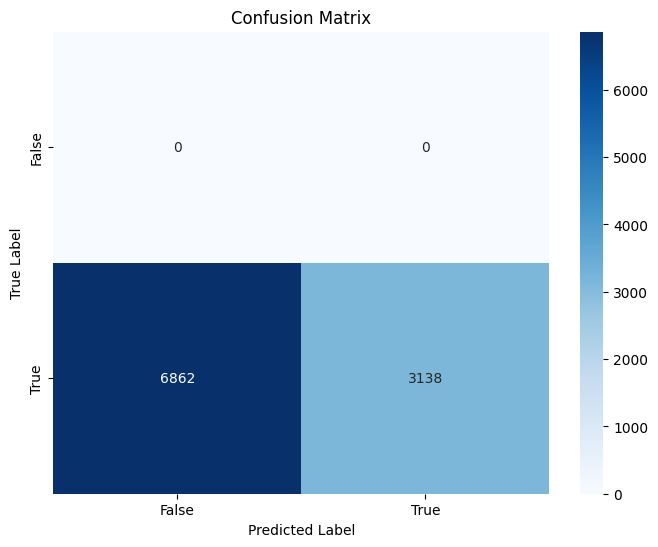


=== Evaluation Results ===
Overall Accuracy: 0.3138

Classification Report:
              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.31      0.48     10000

    accuracy                           0.31     10000
   macro avg       0.50      0.16      0.24     10000
weighted avg       1.00      0.31      0.48     10000


Detailed Metrics:
accuracy: 0.3138
true_positives: 3138
false_positives: 0
true_negatives: 0
false_negatives: 6862
precision: 1.0000
recall: 0.3138

=== Sample of Incorrect Predictions ===

Example 1:
Question: Rationalize the denominator of $\frac{3}{2\sqrt[3]{5}}$. The answer can be written in the form of $\frac{A\sqrt[3]{B}}{C}$, where $A$, $B$, and $C$ are integers, $C$ is positive, and $B$ is not divisible by the cube of any prime. Find $A+B+C$.
Answer: 6
Predicted: False, True: True

Example 2:
Question: Jerry works as an independent contractor for a company that pays him $40 per ta

In [21]:
def evaluate_submission(submission_path, test_dataset):
    """
    Evaluates the accuracy of submission file against test dataset ground truth.

    Args:
        submission_path (str): Path to the submission CSV file
        test_dataset: The test dataset containing ground truth

    Returns:
        dict: Dictionary containing accuracy metrics
    """
    import pandas as pd
    from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
    import matplotlib.pyplot as plt
    import seaborn as sns

    # Read submission file
    predictions_df = pd.read_csv("/content/submission.csv")

    # Get ground truth
    ground_truth = test_dataset['is_correct']

    # Calculate metrics
    accuracy = accuracy_score(ground_truth, predictions_df['is_correct'])
    conf_matrix = confusion_matrix(ground_truth, predictions_df['is_correct'])
    class_report = classification_report(ground_truth, predictions_df['is_correct'])

    # Create confusion matrix visualization
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=['False', 'True'],
                yticklabels=['False', 'True'])
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    # Calculate additional metrics
    true_positives = conf_matrix[1][1]
    false_positives = conf_matrix[0][1]
    true_negatives = conf_matrix[0][0]
    false_negatives = conf_matrix[1][0]

    metrics = {
        'accuracy': accuracy,
        'true_positives': true_positives,
        'false_positives': false_positives,
        'true_negatives': true_negatives,
        'false_negatives': false_negatives,
        'precision': true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0,
        'recall': true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    }

    # Print detailed results
    print("\n=== Evaluation Results ===")
    print(f"Overall Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(class_report)
    print("\nDetailed Metrics:")
    for metric, value in metrics.items():
        if isinstance(value, float):
            print(f"{metric}: {value:.4f}")
        else:
            print(f"{metric}: {value}")

    # Analyze incorrect predictions
    incorrect_predictions = []
    for idx, (pred, true) in enumerate(zip(predictions_df['is_correct'], ground_truth)):
        if pred != true:
            incorrect_predictions.append({
                'index': idx,
                'question': test_dataset['question'][idx],
                'answer': test_dataset['answer'][idx],
                'predicted': pred,
                'true': true
            })

    if incorrect_predictions:
        print("\n=== Sample of Incorrect Predictions ===")
        for i, incorrect in enumerate(incorrect_predictions[:5]):  # Show first 5 incorrect predictions
            print(f"\nExample {i+1}:")
            print(f"Question: {incorrect['question']}")
            print(f"Answer: {incorrect['answer']}")
            print(f"Predicted: {incorrect['predicted']}, True: {incorrect['true']}")

    return metrics

if __name__ == "__main__":
    metrics = evaluate_submission('submission.csv', dataset['test'])